In [1]:
# !pip install segmentation_models --user
# !pip install albumentations --user

In [1]:
import os
import cv2

import pandas as pd
import numpy as np

from torch.utils.data import Dataset

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
DATA_DIR = '../../data/dataset/train/'

IMAGES_DIR = os.path.join(DATA_DIR, 'images')
MASKS_DIR = os.path.join(DATA_DIR, 'borders10')

FOLDS_CSV = os.path.join(DATA_DIR, 'folds.csv')
OOF = 0

In [5]:
CHECKPOINTS_DIR = '../../checkpoints/exp-5'
os.makedirs(CHECKPOINTS_DIR)

### Dataset

In [6]:
def read_image(path):
    return cv2.imread(path)[..., ::-1].copy()

def read_mask(path):
    return cv2.imread(path, 0).squeeze() / 255



class BuildingsDataset(Dataset):
    
    def __init__(self, ids, images_dir, masks_dir, transform=None):
        self.ids = ids
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        
        print('Reading images...')
        self.images = {id: read_image(os.path.join(images_dir, id)) for id in ids}
        
        print('Reading masks...')
        self.masks = {id: read_mask(os.path.join(masks_dir, id)) for id in ids}
        
    def __getitem__(self, i):
        
        id = self.ids[i]
        
        sample = {
            'image': self.images[id],
            'mask': self.masks[id],
        }
        
        if self.transform is not None:
            sample = self.transform(sample)
            
        return sample
        
    def __len__(self):
        return len(self.ids)

### Augmentation

In [7]:
import albumentations as alb

In [8]:
train_transfroms = [
    
    alb.RandomCrop(600, 600),
    
    alb.Flip(p=0.75),
    alb.Transpose(p=0.5),
    alb.RandomRotate90(p=0.5),
    
    alb.ShiftScaleRotate(shift_limit=0, rotate_limit=15, scale_limit=0.1, p=0.3),
    
    alb.CenterCrop(512, 512),
]

valid_transfroms = [
    
    alb.CenterCrop(5120, 5120)
]

train_aug = alb.Compose(train_transfroms)
valid_aug = alb.Compose(valid_transfroms)

### Transformations

In [9]:
import sys
sys.path.append('..')

In [10]:
from utils.datasets import make_transform

In [11]:
train_transform = make_transform(augmenter=train_aug)
valid_transform = make_transform(augmenter=valid_aug)

### Lodaing data

In [12]:
folds_df = pd.read_csv(FOLDS_CSV)

In [13]:
train_ids = [id + '.png' for id in folds_df[folds_df.fold != OOF].ImageId.values]
valid_ids = [id + '.png' for id in folds_df[folds_df.fold == OOF].ImageId.values]

print('Train', train_ids)
print('Valid', valid_ids)

Train ['SQ77SFLTIREZWKAX.png', 'E60M2WMELMJVAPBB.png', 'YTS6DUZYSW5KADN1.png', 'E1QZENNLNLCXBKPN.png', '8B7JP60TYSMLOTJO.png', 'LJJ5AQ6GYW6L2M8D.png', 'A14OK5A65AR5AOST.png']
Valid ['AZ74029PBGFI0291.png', 'T4ZUFU91883CRMQ3.png', 'FOCNEZJJ9UP6IPIC.png']


In [14]:
train_dataset = BuildingsDataset(train_ids, IMAGES_DIR, MASKS_DIR, transform=train_transform)
valid_dataset = BuildingsDataset(valid_ids, IMAGES_DIR, MASKS_DIR, transform=valid_transform)

Reading images...
Reading masks...
Reading images...
Reading masks...


### Visualization

In [15]:
import matplotlib.pyplot as plt

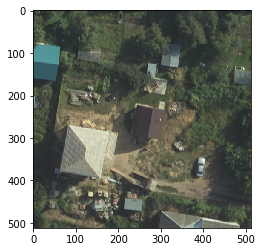

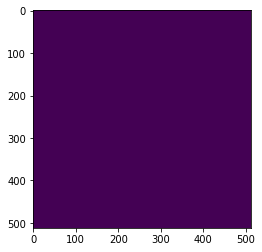

In [26]:
sample = train_dataset[0]

image = sample['image']
mask = sample['mask']

plt.imshow(image)
plt.show()
plt.imshow(mask.squeeze())
plt.show()

### Generators

In [27]:
import keras_backend
from keras_backend.generators import segmentation_generator

from torch.utils.data import WeightedRandomSampler

In [28]:
train_sampler = WeightedRandomSampler(
    weights=[1] * len(train_dataset),
    num_samples = 100000,
)

In [36]:
train_gen = segmentation_generator(train_dataset, batch_size=24, sampler=train_sampler)
valid_gen = segmentation_generator(valid_dataset, batch_size=1)

### Building network

In [30]:
from keras.models import Model
from keras import layers
from keras.optimizers import Adam

from segmentation_models import Unet
from segmentation_models.backbones import get_preprocessing

from keras_backend.losses import bce_jaccard_loss
from keras_backend.metrics import custom_f_score

Using TensorFlow backend.


In [31]:
model = Unet('resnet18')

### Callbacks

In [32]:
from keras.callbacks import ModelCheckpoint, TensorBoard

In [33]:
callbacks = [
    
    ModelCheckpoint(
        os.path.join(CHECKPOINTS_DIR, 'ep_{epoch}-score_{val_score:.5}.h5'), 
        monitor='val_score', 
        save_best_only=True,
        verbose=True,
        mode='max'
    ),

]

### Compilation

In [34]:
optimizer = Adam(1e-4)

loss = bce_jaccard_loss

f1_score = custom_f_score(beta=1)
f2_score = custom_f_score(beta=2)
                          
metrics = [f1_score, f2_score]

In [35]:
model.compile(optimizer, loss, metrics)

### Traininig

In [47]:
model.fit_generator(
    train_gen, 
    steps_per_epoch=100, 
    validation_data=valid_gen, 
    validation_steps=3, 
    initial_epoch=14,
    epochs=50, 
    callbacks=callbacks,
)

Epoch 15/50
100/100 [==============================] - 70s 703ms/step - loss: 0.9015 - score: 0.1807 - score_1: 0.2284 - val_loss: 0.9332 - val_score: 0.1486 - val_score_1: 0.1853

Epoch 00015: val_score improved from 0.12225 to 0.14856, saving model to ../../checkpoints/exp-5/ep_15-score_0.14856.h5
Epoch 16/50
100/100 [==============================] - 70s 701ms/step - loss: 0.8797 - score: 0.2036 - score_1: 0.2457 - val_loss: 0.9308 - val_score: 0.1528 - val_score_1: 0.1886

Epoch 00016: val_score improved from 0.14856 to 0.15282, saving model to ../../checkpoints/exp-5/ep_16-score_0.15282.h5
Epoch 17/50
100/100 [==============================] - 70s 697ms/step - loss: 0.8683 - score: 0.2169 - score_1: 0.2555 - val_loss: 0.9133 - val_score: 0.1704 - val_score_1: 0.1951

Epoch 00017: val_score improved from 0.15282 to 0.17035, saving model to ../../checkpoints/exp-5/ep_17-score_0.17035.h5
Epoch 18/50
100/100 [==============================] - 75s 746ms/step - loss: 0.8526 - score: 0.2

100/100 [==============================] - 68s 676ms/step - loss: 0.4941 - score: 0.9429 - score_1: 1.9986 - val_loss: 0.7589 - val_score: 0.3805 - val_score_1: 0.3506

Epoch 00047: val_score did not improve
Epoch 48/50
100/100 [==============================] - 68s 676ms/step - loss: 0.5037 - score: 0.9334 - score_1: 1.9965 - val_loss: 0.7572 - val_score: 0.3789 - val_score_1: 0.3431

Epoch 00048: val_score did not improve
Epoch 49/50
100/100 [==============================] - 68s 675ms/step - loss: 0.4986 - score: 0.9441 - score_1: 2.0260 - val_loss: 0.7231 - val_score: 0.4355 - val_score_1: 0.4158

Epoch 00049: val_score did not improve
Epoch 50/50
100/100 [==============================] - 67s 675ms/step - loss: 0.4895 - score: 0.9518 - score_1: 2.0256 - val_loss: 0.7145 - val_score: 0.4368 - val_score_1: 0.4093

Epoch 00050: val_score did not improve


### Visualization

In [38]:
def add_mask(image, mask, channel='r', intensity=100):

        r, g, b = image.transpose(2,0,1)
        mask = mask.squeeze() * intensity

        if channel == 'r':
            r = r.astype(np.uint16) + mask.astype(np.uint16)
            r = np.clip(r, 0, 255).astype(np.uint8)

        if channel == 'g':
            g = g.astype(np.uint16) + mask.astype(np.uint16)
            g = np.clip(g, 0, 255).astype(np.uint8)

        if channel == 'b':
            b = b.astype(np.uint16) + mask.astype(np.uint16)
            b = np.clip(b, 0, 255).astype(np.uint8)

        image = np.stack((r, g, b)).transpose(1,2,0)

        return image

In [44]:
sample = valid_dataset[0]

image = sample['image']
mask = sample['mask']

pred = model.predict(image[None, ...])

In [45]:
image_1 = add_mask(image, pred.squeeze(), channel='b', intensity=255)

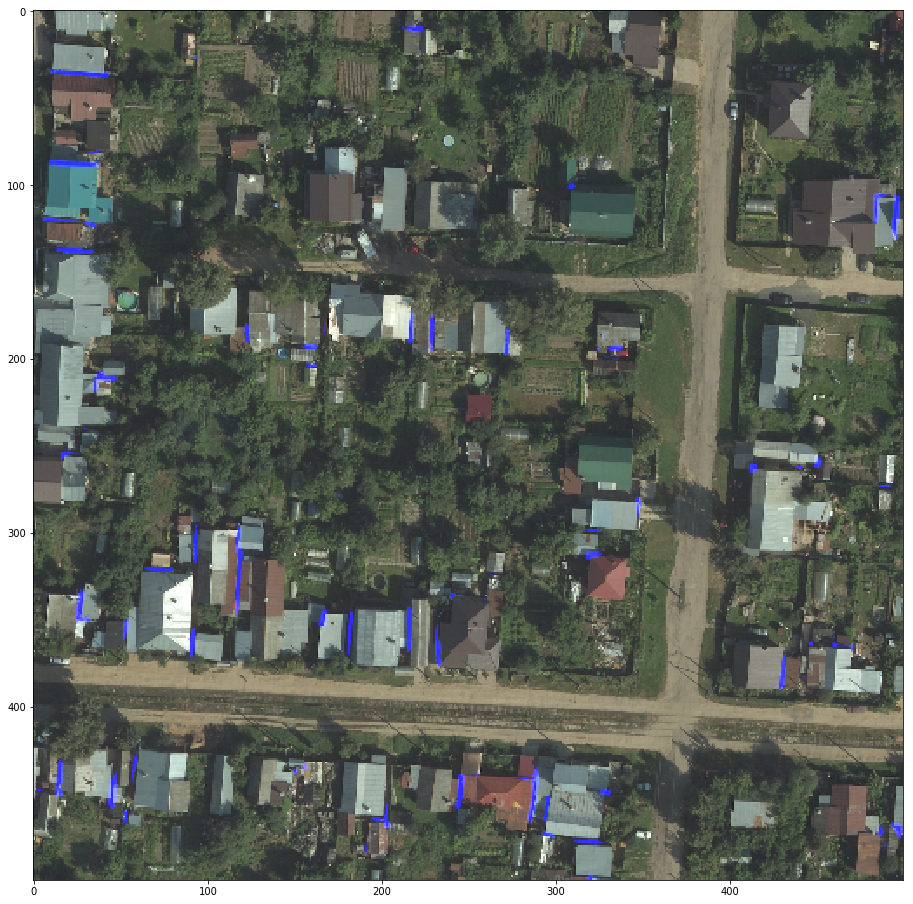

In [46]:
plt.figure(figsize=(16,16))
plt.imshow(image_1[:2000:4, :2000:4])
plt.show()